In [19]:
import os
import logging
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from preprocessing.text_processor import TextProcessor

In [21]:
data_path = "data/labeled/reviews.csv"
teencode_path = "resources/teencode.csv"
stopwords_path = "resources/stopwords.txt"
phrases_path = "resources/phrase_mapping.csv"
output_dir = "models/sentiment-analysis"
log_dir = "log"

In [23]:
# Logging setup
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, "train_sentiment_model.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler(log_file, encoding="utf-8"), logging.StreamHandler()],
)

In [24]:
def load_and_preprocess_data(file_path, processor):
    df = pd.read_csv(file_path)
    df = df[df["label"] != "neu"].dropna(subset=["comment"])
    df["processed"] = df["comment"].apply(lambda x: processor.preprocess(x))
    df = df[df["processed"].str.strip().str.len() >= 2].reset_index(drop=True)
    return df

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC


def train_model(X_train, y_train, model_name="svm"):
    """
    Train a sentiment classification pipeline using the specified model.

    Parameters:
        X_train (array-like): Preprocessed input texts.
        y_train (array-like): Corresponding labels.
        model_name (str): One of 'svm', 'logistic', 'naive_bayes', 'random_forest', 'knn'.

    Returns:
        Pipeline: Trained scikit-learn pipeline
    """
    # Select classifier
    if model_name == "svm":
        clf = LinearSVC(dual="auto")
    elif model_name == "logistic":
        clf = LogisticRegression(max_iter=1000)
    elif model_name == "naive_bayes":
        clf = MultinomialNB()
    elif model_name == "random_forest":
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "knn":
        clf = KNeighborsClassifier(n_neighbors=3)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Define pipeline
    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    max_features=3000, min_df=5, max_df=0.8, sublinear_tf=True
                ),
            ),
            ("clf", clf),
        ]
    )

    pipeline.fit(X_train, y_train)
    return pipeline

In [26]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    return acc, report, cm, preds

In [27]:
# Initialize text processor
processor = TextProcessor(
    teencode_path=teencode_path,
    stopword_path=stopwords_path,
    phrase_mapping_path=phrases_path,
)

In [28]:
logging.info("Loading and preprocessing data...")
df = load_and_preprocess_data(data_path, processor)
X = df["processed"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Training with svm...
✅ Model saved to models/sentiment-analysis/svm.pkl
SVM accuracy: 0.8950

Training with logistic...
✅ Model saved to models/sentiment-analysis/logistic.pkl
LOGISTIC accuracy: 0.8867

Training with naive_bayes...
✅ Model saved to models/sentiment-analysis/naive_bayes.pkl
NAIVE_BAYES accuracy: 0.8867

Training with random_forest...
✅ Model saved to models/sentiment-analysis/random_forest.pkl
RANDOM_FOREST accuracy: 0.9050

Training with knn...
✅ Model saved to models/sentiment-analysis/knn.pkl
KNN accuracy: 0.6458



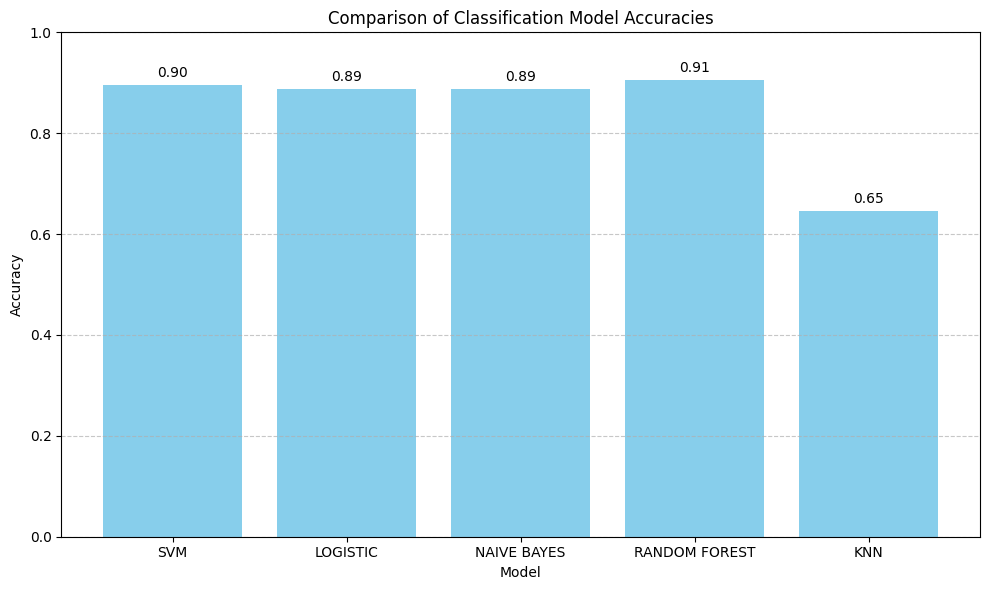

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# List of models to evaluate
models_to_test = ["svm", "logistic", "naive_bayes", "random_forest", "knn"]

accuracies = []  # To store the accuracy of each model

# Train and evaluate each model
for model_name in models_to_test:
    print(
        f"Training with {model_name}..."
    )  # Inform which model is currently being trained

    model = train_model(X_train, y_train, model_name)  # Train the model
    preds = model.predict(X_test)  # Predict on the test set
    acc = accuracy_score(y_test, preds)  # Compute accuracy
    accuracies.append(acc)  # Save accuracy to the list

    logging.info(f"Accuracy: {acc:.4f}")
    os.makedirs(output_dir, exist_ok=True)
    model_path = f"{output_dir}/{model_name}.pkl"
    joblib.dump(model, model_path)
    logging.info(f"Model saved to {model_path}")
    print(f"✅ Model saved to {model_path}")

    print(f"{model_name.upper()} accuracy: {acc:.4f}\n")  # Print accuracy

# Prepare model names for display (capitalize and format)
model_names = [name.upper().replace("_", " ") for name in models_to_test]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color="skyblue")  # Bar chart of model accuracies
plt.title("Comparison of Classification Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Set y-axis range to 0–1 for accuracy
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add horizontal grid lines

# Add accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center", va="bottom")

plt.tight_layout()  # Adjust layout to fit elements
plt.show()  # Display the plot

In [30]:
def load_model(model_path):
    """Load a trained sentiment analysis model from file."""
    try:
        model = joblib.load(model_path)
        logging.info(f"Model loaded from {model_path}")
        return model
    except Exception as e:
        logging.error(f"Failed to load model: {e}")
        exit(1)

In [31]:
comments = [
    "Giao hàng nhanh, sản phẩm đúng như mô tả.",
    "Sách bị rách và giao sai hàng.",
    "Chất lượng ổn, giá cả hợp lý.",
    "Thái độ nhân viên không tốt.",
    "Đóng gói cẩn thận, rất hài lòng.",
    "Xuất sắc"
]

# Initialize text processor
processor = TextProcessor(
    teencode_path=teencode_path,
    stopword_path=stopwords_path,
    phrase_mapping_path=phrases_path,
)

# Load model and preprocess input
model = load_model("models/sentiment-analysis/random_forest.pkl")

# Predict and display results
print("📦 Dự đoán cảm xúc:")
for cmt in comments:
    cleaned = processor.preprocess(cmt)
    label = model.predict([cleaned])[0]
    print(f'🗨️ "{cmt}" → 📌 {label}')

📦 Dự đoán cảm xúc:
🗨️ "Giao hàng nhanh, sản phẩm đúng như mô tả." → 📌 pos
🗨️ "Sách bị rách và giao sai hàng." → 📌 neg
🗨️ "Chất lượng ổn, giá cả hợp lý." → 📌 pos
🗨️ "Thái độ nhân viên không tốt." → 📌 neg
🗨️ "Đóng gói cẩn thận, rất hài lòng." → 📌 pos
🗨️ "Xuất sắc" → 📌 pos
